<img src="./img/oscon.png" width="400">


# Install Checks 
The purpose of this section is to make sure you have all the modules we will use throughout the training. 

--

If you haven't already done so, we recommend that you install TensorFlow in a seperate virtualenv (or conda environment). First create a virtualenv (pip install virtualenv, if you don't have the software installed already). 

~~~bash
$cd ~
$mkdir envs
$virtualenv ~/envs/tensorflow
~~~

Then activate the virtualenv and install TensorFlow (this will be the basic CPU-only version, but that's good enough for now).  

~~~bash
$source ~/envs/tensorflow/bin/activate
(tensorflow)$pip install tensorflow
~~~

Additoinal resources: 
- https://www.tensorflow.org/install/install_mac
- https://www.tensorflow.org/install/install_windows
- https://www.tensorflow.org/install/install_linux


First, we import tensorflow 

In [1]:
import tensorflow as tf

Take note what version of TensorFlow you are currently using. We assume you are using a version $\geq$ 1.0, some (rather small) adaptation might be necessary if you are using a previous version. 

In [2]:
tf.__version__

'1.1.0'

Next, we import some other modules that will be useful throughout the training. Most of these are come with the Anaconda package (but pip install keras).

In [3]:
import numpy as np 
import matplotlib
import sklearn

import pandas as pd 
import keras

Using TensorFlow backend.


The versions of sklearn and kears might also account for some variability in behavior, so that's something to keep an eye out for, if you are not running the latest versions.

In [4]:
print(sklearn.__version__)
print(keras.__version__)

0.18
2.0.4


# Hello World
We kick off with a simple "Hello World" exmaple. While simple and intuitive, this already contains many of the TensorFlow elements we will discuss in depth later.  

In [5]:
h = tf.constant("Hello")
w = tf.constant(" World!")
hw = h + w

with tf.Session() as sess:
    ans = sess.run(hw)

print(ans)

b'Hello World!'


In [6]:
print(h)
print(hw)

Tensor("Const:0", shape=(), dtype=string)
Tensor("add:0", shape=(), dtype=string)


# A first (and simple) TensorFlow classifier 
# MNIST 
The MNIST (Mixed National Institue of Standards and Technology) handwritten digits dataset is one of the most researched datasets in image processing and machine learning, and has played an important role in the development of artificial neural networks.

Our first example will be a simple softmax-regression model on the raw pixels of the digit images. First, let's take a look at the data!

In [7]:
from tensorflow.examples.tutorials.mnist import input_data
import sys

# This is where the MNIST data will be downloaded to. If you already have it on your 
# machine then set the path accordingly to prevent an extra download. 
DATA_DIR = '/tmp/data' if not 'win' in sys.platform else "c:\\tmp\\data"

# Load data 
data = input_data.read_data_sets(DATA_DIR, one_hot=True)

print("Nubmer of training-set images: {}".format(len(data.train.images)))
print("Luckily, there are also {} matching labels.".format(len(data.train.labels)))

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting c:\tmp\data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting c:\tmp\data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting c:\tmp\data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting c:\tmp\data/t10k-labels-idx1-ubyte.gz
Nubmer of training-set images: 55000
Luckily, there are also 55000 matching labels.


Now that we have the dataset loaded we can plot a few examples.

We will start with single images and then plot a batch.

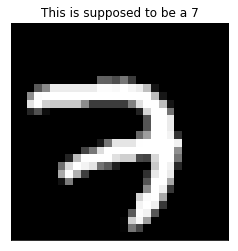

In [8]:
import matplotlib.pyplot as plt 
%matplotlib inline  

IMAGE_IX_IN_DATASET = 0

first_img = data.train.images[IMAGE_IX_IN_DATASET].reshape(28, 28)
first_lbl = data.train.labels[IMAGE_IX_IN_DATASET].argmax()

plt.figure()
plt.imshow(first_img, cmap='gray')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.title("This is supposed to be a {}".format(first_lbl))

In order to plot an entire batch of digits, we stack them both horizontally and vertically, formly a 10X10 grid of digits. 

We then plot the image <b> negative </b> for better visibility. 

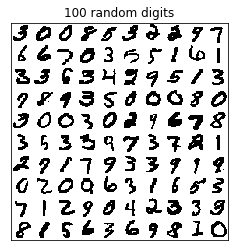

In [9]:
N_IMAGES = 10
img = np.vstack([np.hstack([img.reshape(28, 28) 
                            for img in data.train.images[np.random.choice(1000, N_IMAGES)]])
                 for i in range(N_IMAGES)])
img = np.logical_not(img)

plt.figure()
plt.imshow(img, cmap='gray')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.title("100 random digits")

# Softmax Regression
Put simply, the softmax regression model will figure out for each pixel in the image, which digits tend to have high (or low) values in that location. For instance, the center of the image will tend to be white for zeros, but black for sixes. Thus, a black pixel in the center of an image will be evidence against the image containing a zero, and in favor of it containing a six.

Learning in this model consists of finding weights that tell us how to accumulate evidence for the existence of each of the digits. With softmax regression, we will not use the spatial information in the pixel layout in the image.

$ evidence(i) = \langle x, w_i \rangle \ \  [+b_i]$ 



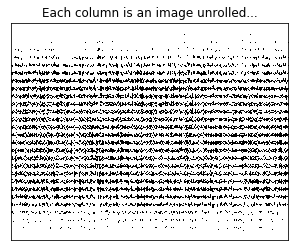

In [10]:
# Get the raw (vector) image and labael -- see what it looks like when not a rectangle
img = data.train.images[:1000]

# Plot 
plt.figure()
plt.imshow(np.logical_not(img).T, cmap='gray')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.title("Each column is an image unrolled...")

At first glance it might look like there is no signal here. We will do two things:
    1. cut out only the center of the digits image (the rest is white-space)
    2. soft the columns by the actual digit represented in the image 
    
Once we do this, we will see that there is actually a clear structure in the individual pixels. While the human eye is not able to recognize the digits (maybe with some practice...), this is enough for the SoftMax model to go on. 

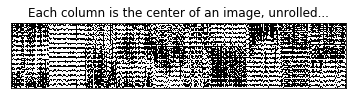

In [11]:

N_IMAGES = 1000

# Cut out the center part of the image (Actual digit)
center_img = [img.reshape(28, 28)[8:22, 8:22].ravel() 
              for img in  data.train.images[:N_IMAGES]]

# Sort by digits
sorted_lbls = np.argsort(data.train.labels.argmax(axis=1)[:N_IMAGES])
center_img = np.array(center_img)[sorted_lbls]

# Plot 
plt.figure()
plt.imshow(np.logical_not(center_img).T, cmap='gray')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.title("Each column is the center of an image, unrolled...")

First, we formulate the actual <b> model </b>.

There are a few elements to notice here:
    1. placehodler
    2. Variable
    3. Dimensions; as in [None, 784]
    4. matmul
    
We will discuss all of these in great detail later on. 

In [12]:
# We start by building the model 
x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))

y_true = tf.placeholder(tf.float32, [None, 10])
y_pred = tf.matmul(x, W)

The next element we need is the <b> objective </b> (a.k.a loss). 

In [13]:
cross_entropy = \
    tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y_true))

The parameters of the model -- the W matrix are optimized using Gradient Descent. This method essentially consists of taking many small steps in the right direction. But more about that later... 

In [14]:
gd_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

The final elements we need are measures of how well our model is preforming.
    1. correct_mask: an indicator per sample whether or not it is labeled correctly
    2. accuracy: the fraction of samples labeled correctly 

In [15]:
correct_mask = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
accuracy = tf.reduce_mean(tf.cast(correct_mask, tf.float32))

We now have all the necessary elements in place and we are ready to run the model. Recall that in TensorFlow we first define a computation graph and then run it. The next part deals with running the model.

In [16]:
NUM_STEPS = 1000
MINIBATCH_SIZE = 100

with tf.Session() as sess:

    # Train
    sess.run(tf.global_variables_initializer())
    for _ in range(NUM_STEPS):
        batch_xs, batch_ys = data.train.next_batch(MINIBATCH_SIZE)
        sess.run(gd_step, feed_dict={x: batch_xs, y_true: batch_ys})

    # Test
    is_correct, acc = sess.run([correct_mask, accuracy], 
                               feed_dict={x: data.test.images, y_true: data.test.labels})

print("Accuracy: {:.4}%".format(acc*100))


Accuracy: 91.69%


# Which images did we get wrong?
The softmax-regression model gets approx. 8% of the test-set wrong! Later on when we use CNNs things will look much better... (State of the art systems achieve virtually perfect accuracy on this dataset).

But first let's take a look at which digit images we got right, and which we got wrong. Recall softmax-regression doesn't model the relationship between pixels, but rather considers them independently. Does this explain some of the errors we see?   

In [17]:
is_correct

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

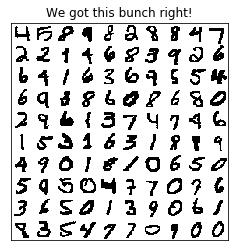

In [18]:
correct_ix = np.where(is_correct)[0]
correct_img = data.train.images[correct_ix]

N_IMAGES = 10
img = np.vstack([np.hstack([img.reshape(28, 28) 
                            for img in correct_img[np.random.choice(len(correct_ix), N_IMAGES)]])
                 for i in range(N_IMAGES)])
img = np.logical_not(img)

plt.figure()
plt.imshow(img, cmap='gray')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.title("We got this bunch right!")

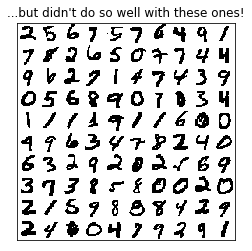

In [19]:
incorrect_ix = np.where(np.logical_not(is_correct))[0]
incorrect_img = data.train.images[incorrect_ix]

N_IMAGES = 10
img = np.vstack([np.hstack([img.reshape(28, 28) 
                            for img in incorrect_img[np.random.choice(len(incorrect_ix), N_IMAGES)]])
                 for i in range(N_IMAGES)])
img = np.logical_not(img)

plt.figure()
plt.imshow(img, cmap='gray')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.title("...but didn't do so well with these ones!")

# Exercises
## 1. Confusion matrix 
A confusion matrix is a table where the [i ,j]-th element details the number of examples from class i which were classified as class j. The diagonal reprsents correct classification, and other elements represent the types of error that occur. 

### 1.1 Construct and print the confusion matrix for the softmax regression model and the MNIST dataset. 

### 1.2 Which digits are most confused with which? Is it symmetric? Does this make sense?


useful hints:
1. 
~~~python 
from sklearn.metrics import confusion_matrix 
~~~
2. 
~~~python
sess.run([y_true, y_pred ]... 
~~~

## 2. Softmax regression with a bias term
It is common to add a scalar "bias" term to the regression formulation:

$ evidence(i) = \langle x, w_i \rangle + b_i $ 

### 2.1 Add a bias term to the TF model

### 2.2 Did the results chnage? Explain...

---
Solutions can be loaded in the next Cells.

Also available at: https://github.com/Hezi-Resheff/Oreilly-OSCON2017-Learning-TensorFlow/tree/master/solutions


In [20]:
# %load ../solutions/intro_ex1.py

In [21]:
# %load ../solutions/intro_ex2.py